In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from pathos.multiprocessing import Pool
from sklearn.model_selection import KFold
import itertools

from scipy.optimize import leastsq, nnls, lsq_linear
import analyze_tools.opt as opt

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:]
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 6000.0, min nonzero counts = 1.0
max counts = 4276.0, min nonzero counts = 1724.0


In [3]:

data = traj2.counts
expected = traj2.dcounts_dt
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
large_theta = np.array([f(data) for f in bfc.functions])
large_theta = np.transpose(large_theta, axes=(1, 0, 2))

def minimizing_fun(coeffs):
    out = np.empty((traj2.n_species * traj2.n_time_steps), dtype=data.dtype)
    opt.least_squares_function(out, coeffs, large_theta, expected, scale)
    return out

coeffs, _ = leastsq(minimizing_fun, np.array([.5]*bfc.n_basis_functions), ftol=1e-16, xtol=1e-12)

In [4]:
print(coeffs)

[  2.05826666e-06   7.12585263e-06  -6.03120806e-06  -1.08586090e-06
  -4.77349710e-03   8.82579124e-03  -1.92327569e-06  -1.77939222e-02
   3.75534546e-03]


/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


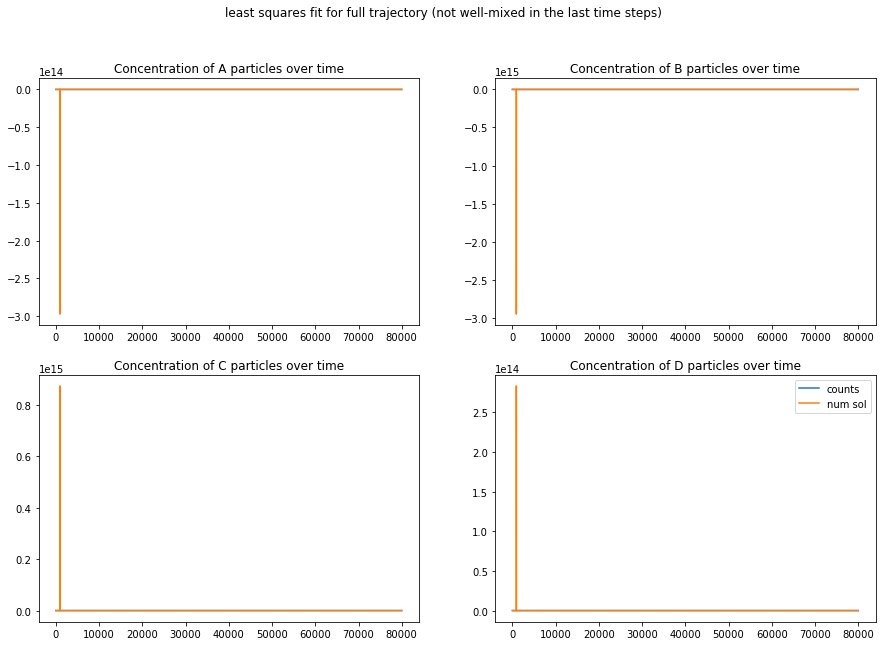

In [5]:
full_traj = traj2

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]

def fun(d, _):
    theta = np.array([f(d) for f in bfc.functions])
    return np.matmul(coeffs, theta)
num_sol = odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    axes[i].plot(np.arange(0, full_traj.n_time_steps), num_sol[:, i], label="num sol")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

In [6]:
def find_initial_xi(traj, bfc, x_0):
    x0 = np.array(x_0)
    large_theta = np.array([f(data) for f in bfc.functions])
    large_theta = np.transpose(large_theta, axes=(1, 0, 2))
    print(large_theta.shape)
    result = np.zeros_like(x0)
    single_coeffs = []
    for s in range(traj.n_species):
        counts_for_species = traj.counts[:, s]
        dcounts_dt_for_species = traj.dcounts_dt[:, s]
        theta = large_theta[:, :, s]
        
        # x0_new, residual = nnls(theta, dcounts_dt_for_species)
        x0_new = lsq_linear(theta, dcounts_dt_for_species, bounds=(0, np.inf))
        # x0 = x0_new
        single_coeffs.append(x0_new.x)
        result += x0_new.x
    return result, single_coeffs

In [7]:
coefficients, single_coeffs = find_initial_xi(traj2, bfc, [.0]*bfc.n_basis_functions)

(80001, 9, 4)


max counts = 6000.0, min nonzero counts = 1.0
[  0.00000000e+00   1.90551152e+00   3.37187036e+00 ...,   4.59042062e+03
   4.59042062e+03   4.59042062e+03]


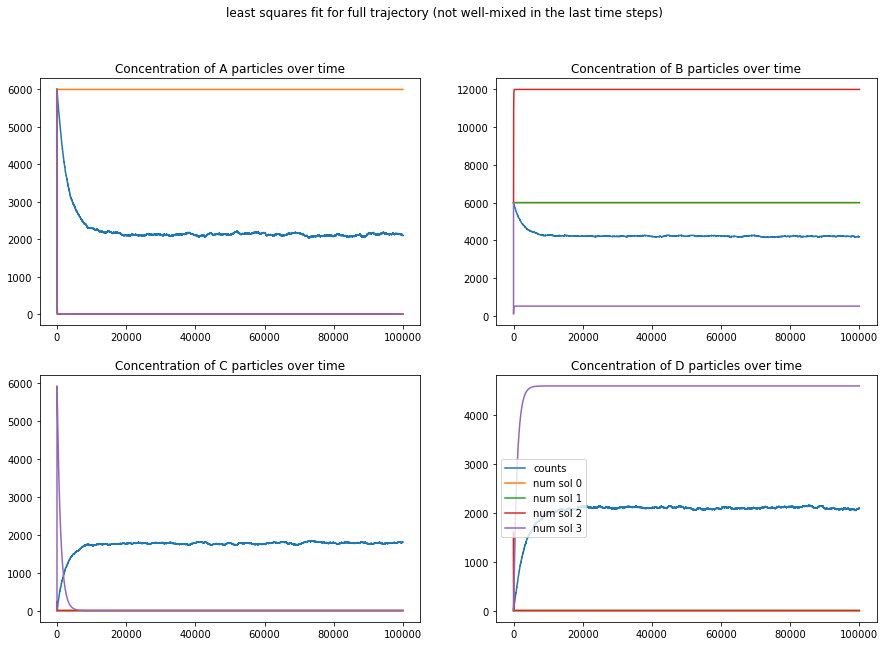

In [8]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]

def fun(d, _):
    theta = np.array([f(d) for f in bfc.functions])
    return np.matmul(coefficients, theta)
num_sol = odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps))

solns = []
for coeffs in single_coeffs:
    def fun(d, _):
        theta = np.array([f(d) for f in bfc.functions])
        res = np.matmul(coeffs, theta)
        return res
    solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    # axes[i].plot(np.arange(0, full_traj.n_time_steps), num_sol[:, i], label="num sol")
    for idx, sol in enumerate(solns):
        axes[i].plot(np.arange(0, full_traj.n_time_steps), sol[:, i], label="num sol %s" % idx)
        if idx == 3 and i == 3:
            print(sol[:,i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

In [9]:
import scipy.sparse as spsp

In [ ]:
x0 = np.array(x_0)
large_theta = np.array([f(data) for f in bfc.functions])
large_theta = np.transpose(large_theta, axes=(1, 0, 2))
print(large_theta.shape)
result = np.zeros_like(x0)
single_coeffs = []
thetas = []
for s in range(traj.n_species):
    counts_for_species = traj.counts[:, s]
    dcounts_dt_for_species = traj.dcounts_dt[:, s]
    theta = large_theta[:, :, s]
    thetas.append(theta)
    # x0_new, residual = nnls(theta, dcounts_dt_for_species)
    x0_new = lsq_linear(theta, dcounts_dt_for_species, bounds=(0, np.inf))
    # x0 = x0_new
    single_coeffs.append(x0_new.x)
    result += x0_new.x